### Importling Libraries

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Loading Data & Removing Unwanted Columns

We've decided to choose the columns: 
- Wind speed (m/s)
- Wind direction (°)
- Energy Export (kWh)
- Energy Import (kWh)
- Nacelle ambient temperature (°C)
- Power (kW)

In [236]:
df = pd.read_csv("../dataset/Turbine_Data_Kelmarsh_1_2022-01-01_-_2023-01-01_228.csv")
df = df[
    ["Date and time", "Wind speed (m/s)", "Wind direction (°)", "Energy Export (kWh)", "Energy Import (kWh)",
     "Nacelle ambient temperature (°C)", "Power (kW)"]
]
df.head(10)

,Date and time,Wind speed (m/s),Wind direction (°),Energy Export (kWh),Energy Import (kWh),Nacelle ambient temperature (°C),Power (kW)
0,2022-01-01 00:00:00,6.781222,185.795348,126.0,0.001887,12.4775,630.889598
1,2022-01-01 00:10:00,6.936052,189.458687,116.0,0.001887,12.4925,809.339449
2,2022-01-01 00:20:00,7.294642,188.648729,122.0,0.001887,12.5225,893.607333
3,2022-01-01 00:30:00,8.080467,188.826550,211.0,0.001887,12.5700,995.583734
4,2022-01-01 00:40:00,7.021328,191.252213,136.0,0.001887,12.5925,926.519441
5,2022-01-01 00:50:00,7.501484,197.381405,145.0,0.001887,12.7250,955.778409
6,2022-01-01 01:00:00,6.914297,194.880139,163.0,0.001887,12.8200,746.642319
7,2022-01-01 01:10:00,6.206490,196.504254,88.0,0.001887,12.9000,570.319664
8,2022-01-01 01:20:00,7.046499,191.961852,100.0,0.001887,12.9650,744.511908
9,2022-01-01 01:30:00,6.697301,191.663985,148.0,0.001887,13.0550,691.198062


### Combine Values to Hourly Values

In [237]:
# convert the date and time column to a datetime object
df['Date and time'] = pd.to_datetime(df['Date and time'])

# we have to set an index to resample the data
df = df.set_index('Date and time')
df = df.resample('h').mean()
df.reset_index(inplace=True)
df.head(10)

,Date and time,Wind speed (m/s),Wind direction (°),Energy Export (kWh),Energy Import (kWh),Nacelle ambient temperature (°C),Power (kW)
0,2022-01-01 00:00:00,7.269199,190.227156,142.666667,0.001887,12.563333,868.619661
1,2022-01-01 01:00:00,7.180542,193.224615,140.833333,0.001887,12.990000,852.641219
2,2022-01-01 02:00:00,7.924514,193.560177,191.000000,0.001887,13.194167,1104.675791
3,2022-01-01 03:00:00,7.761178,191.599643,179.333333,0.001887,13.194759,1090.165807
4,2022-01-01 04:00:00,8.062870,180.961708,198.666667,0.001887,12.830417,1213.768762
5,2022-01-01 05:00:00,7.722988,183.699565,176.166667,0.001887,12.827917,1049.194522
6,2022-01-01 06:00:00,8.574013,184.390006,229.333333,0.001887,12.829583,1398.837987
7,2022-01-01 07:00:00,9.009174,191.631940,260.333333,0.001887,12.921667,1574.270566
8,2022-01-01 08:00:00,10.426002,194.245152,325.166667,0.001887,13.093658,1946.605583
9,2022-01-01 09:00:00,10.111206,191.243481,318.166667,0.001887,13.253311,1913.928536


### Handle Missing Values

In [238]:
df.isnull().sum()

Date and time                        0
Wind speed (m/s)                    86
Wind direction (°)                  86
Energy Export (kWh)                  0
Energy Import (kWh)                 10
Nacelle ambient temperature (°C)    93
Power (kW)                          86
dtype: int64

In [239]:
# drop rows with missing power values, as they are the target values
df = df.dropna(subset=['Power (kW)'])

# drop rows with missing energy export and import values
df = df.dropna(subset=['Energy Export (kWh)', 'Energy Import (kWh)'])

# calculate missing wind speed by taking the average of the last 5 values and the next 5 values if possible
df.loc[:, 'Wind speed (m/s)'] = df['Wind speed (m/s)'].fillna(
    df['Wind speed (m/s)'].rolling(10, min_periods=1).mean().ffill().bfill())

# calculate missing nacelle ambient temperature by taking the average of the last 5 values and the next 5 values if possible
df.loc[:, 'Nacelle ambient temperature (°C)'] = df['Nacelle ambient temperature (°C)'].fillna(
    df['Nacelle ambient temperature (°C)'].rolling(10, center=True, min_periods=1).mean().ffill().bfill())

In [240]:
df.isnull().sum()

Date and time                       0
Wind speed (m/s)                    0
Wind direction (°)                  0
Energy Export (kWh)                 0
Energy Import (kWh)                 0
Nacelle ambient temperature (°C)    0
Power (kW)                          0
dtype: int64

### Creating new Columns

In [241]:
# split the Date and time column into separate columns
df["Month"] = df["Date and time"].dt.month
df["Hour"] = df["Date and time"].dt.hour

# drop the Date and time column
df = df.drop(columns=["Date and time"])

# reorder the columns
df = df[["Month", "Hour", "Wind speed (m/s)", "Wind direction (°)", "Energy Export (kWh)",
         "Energy Import (kWh)", "Nacelle ambient temperature (°C)", "Power (kW)"]]

### Exploration

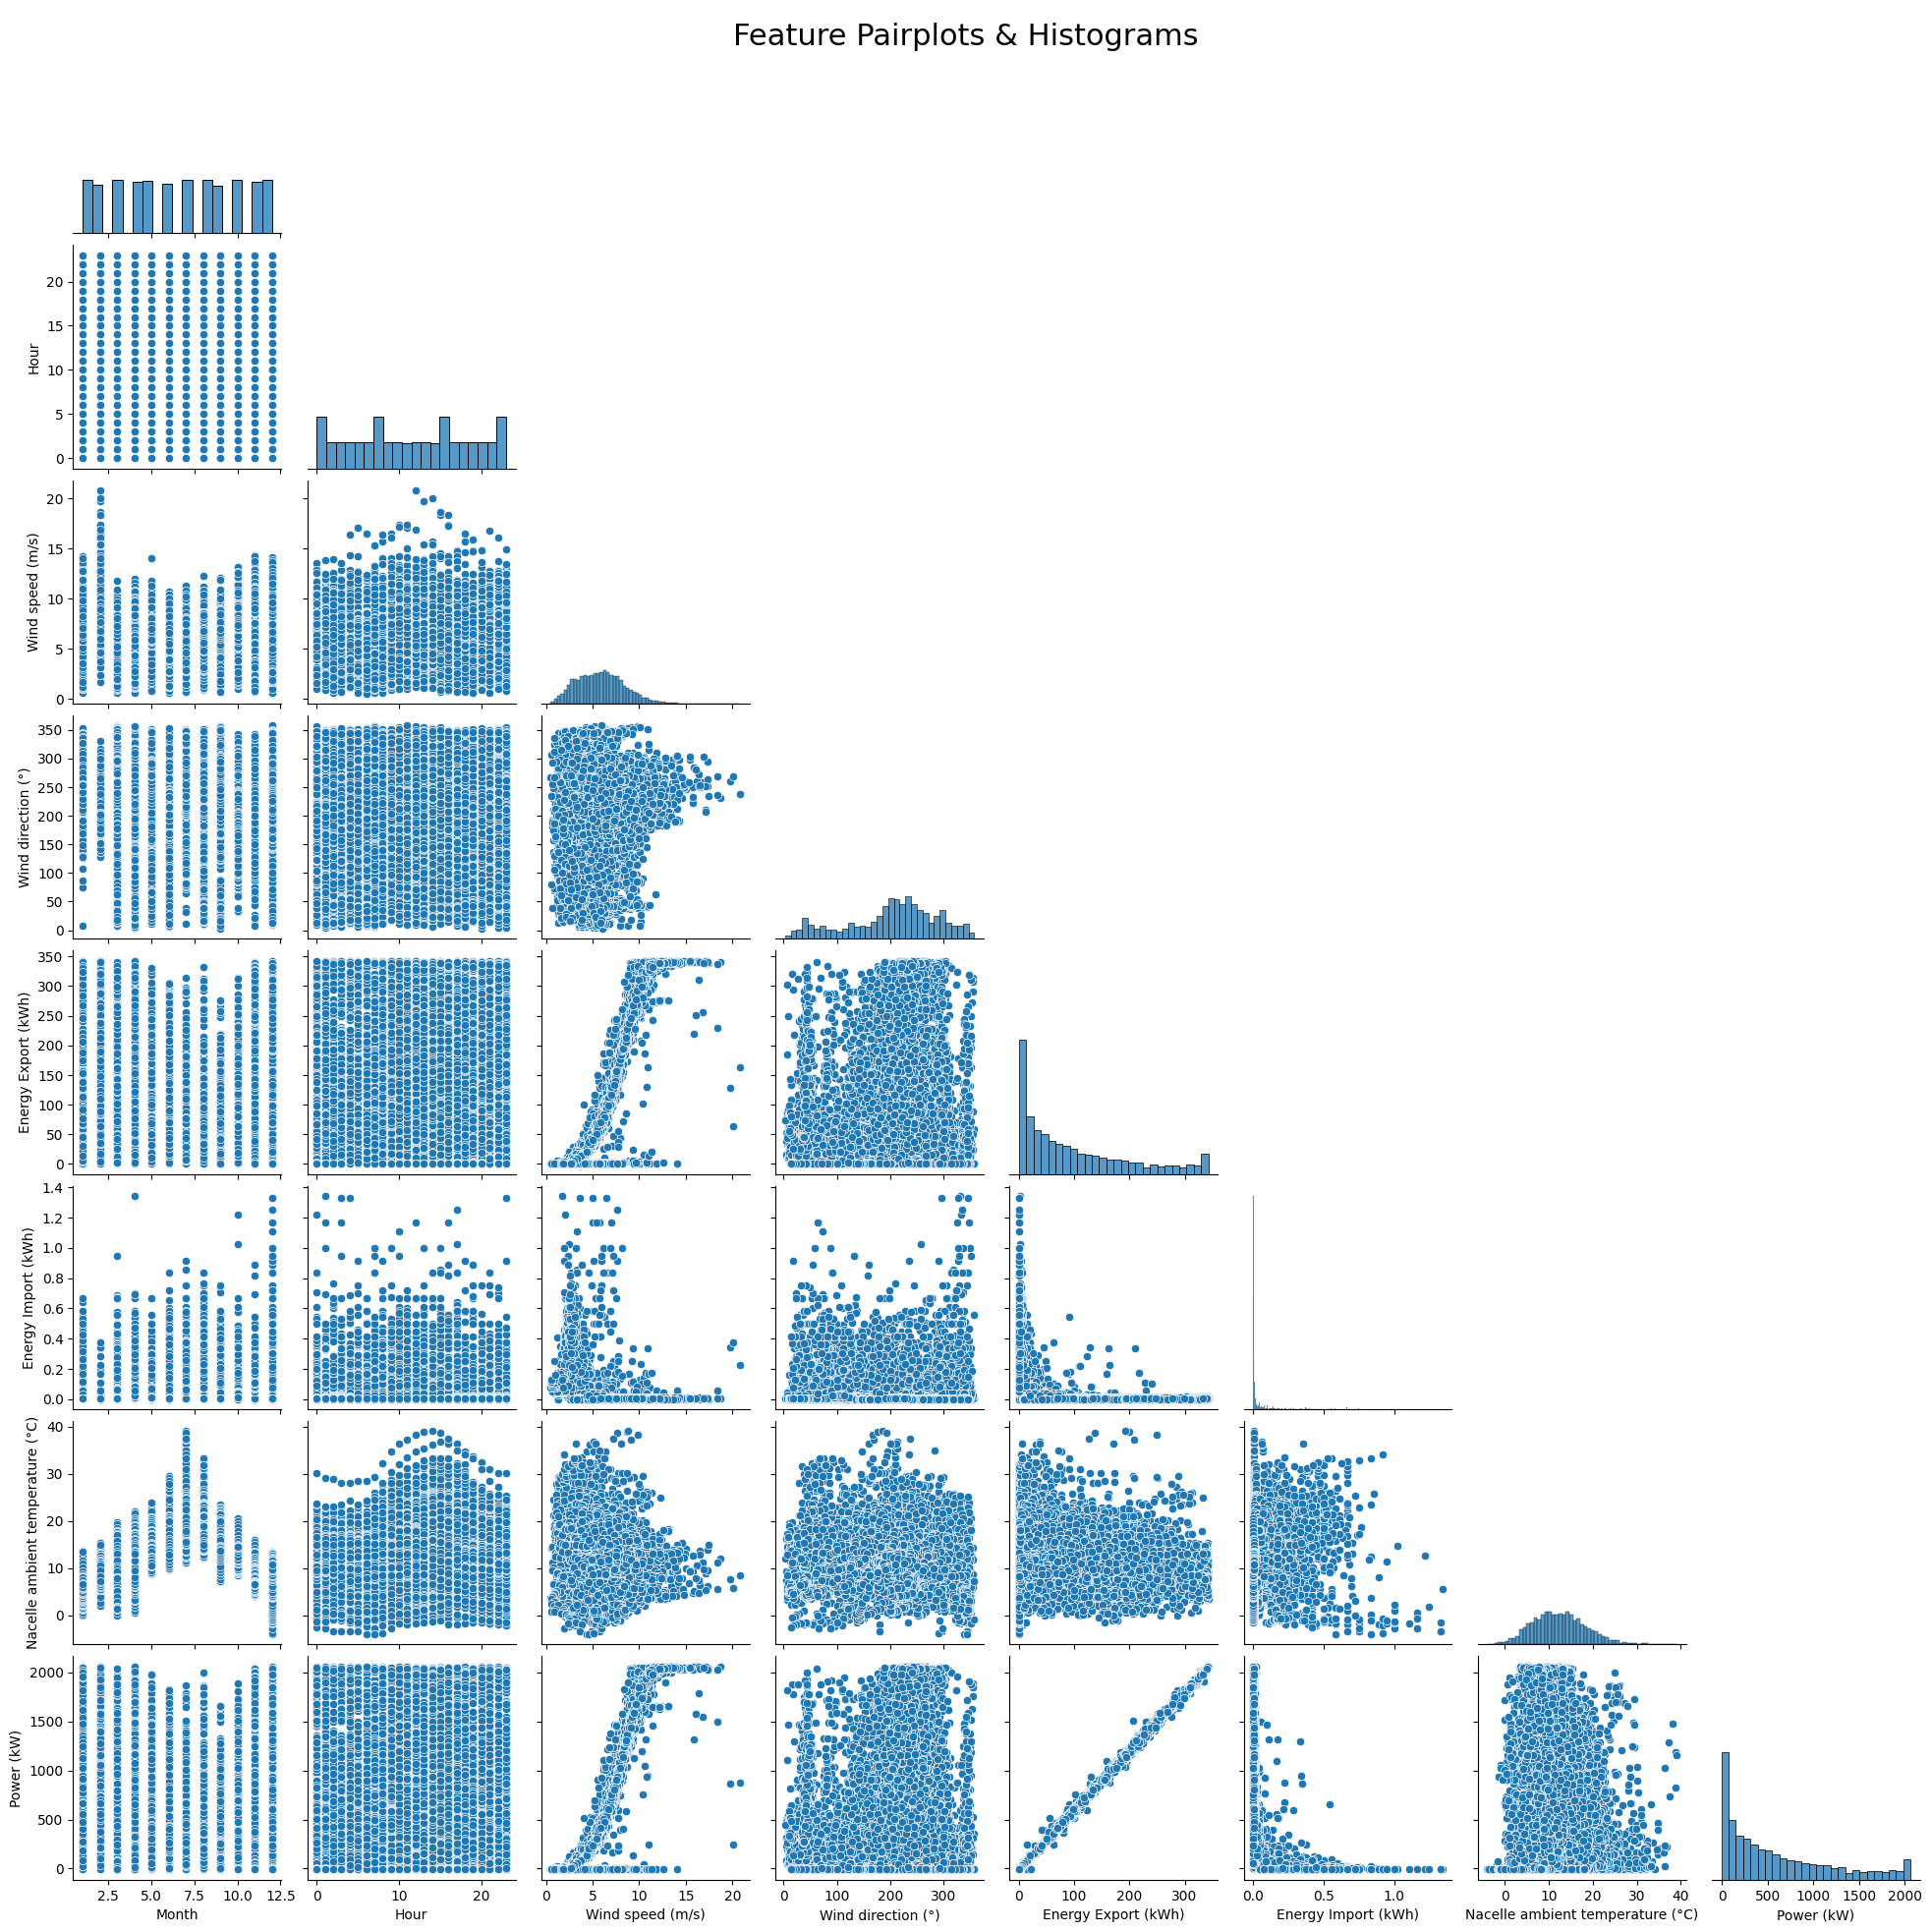

In [242]:
p = sns.pairplot(df, corner=True)
p.fig.suptitle('Feature Pairplots & Histograms', fontsize=22)
plt.show()

In [243]:
df.describe()

,Month,Hour,Wind speed (m/s),Wind direction (°),Energy Export (kWh),Energy Import (kWh),Nacelle ambient temperature (°C),Power (kW)
count,8664.000000,8664.000000,8664.000000,8664.000000,8664.000000,8664.000000,8664.000000,8664.000000
mean,6.515120,11.491459,5.965699,202.510514,99.190104,0.057221,12.497719,594.840523
std,3.461202,6.926998,2.619935,84.868125,98.208890,0.130079,6.186006,589.685555
min,1.000000,0.000000,0.521802,2.743750,0.000000,0.000000,-3.993333,-9.279618
25%,4.000000,5.000000,3.994499,151.055933,17.458333,0.001883,8.079665,104.284738
50%,7.000000,11.000000,5.841397,214.203339,66.666667,0.005525,12.156767,401.904945
75%,10.000000,17.250000,7.632158,261.564927,157.000000,0.033512,16.455208,939.946209
max,12.000000,23.000000,20.811007,357.556542,342.833333,1.343750,39.030504,2061.835481


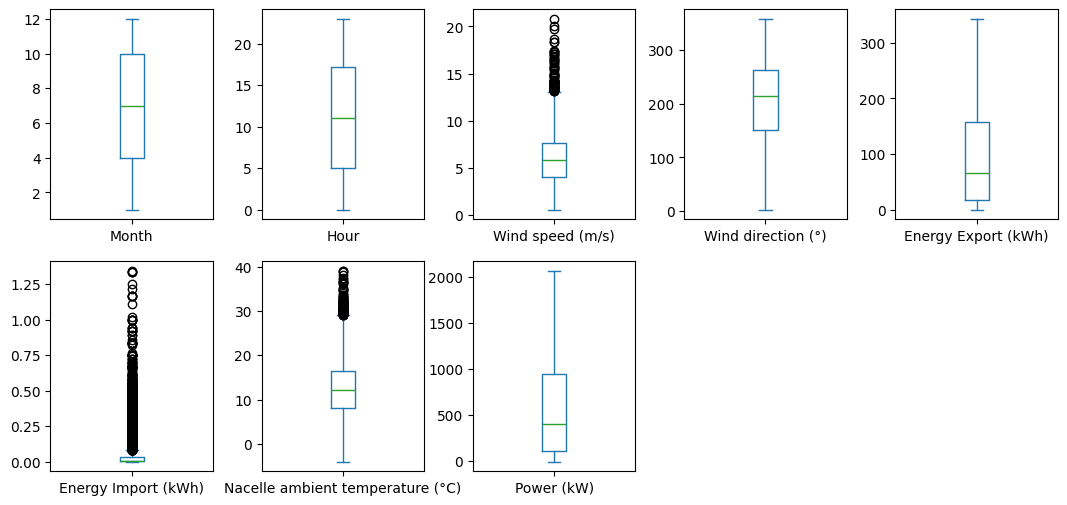

In [244]:
df.plot.box(subplots=True, figsize=(13, 6), layout=(2, 5))
plt.subplots_adjust(wspace=.3)
plt.show()

### Simple Linear Regression

In [249]:
X = df.iloc[:, 2:3].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simple Linear Regression

In [250]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

### Visualising the Training Set Results

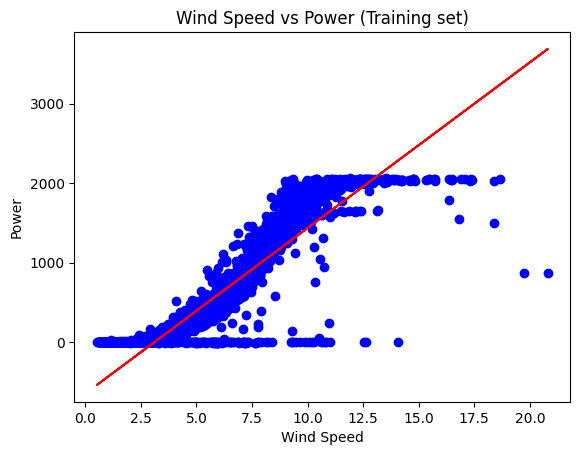

In [251]:
plt.scatter(X_train, y_train, color='blue')
plt.plot(X_train, regressor.predict(X_train), color='red')
plt.title('Wind Speed vs Power (Training set)')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.show()

### Visualising the Test Set Results

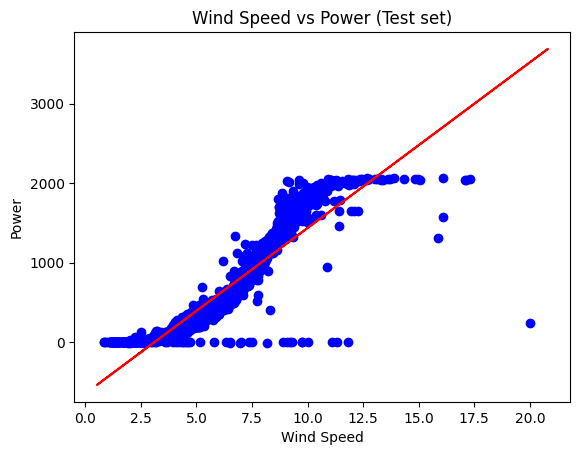

In [252]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_train, regressor.predict(X_train), color='red')
plt.title('Wind Speed vs Power (Test set)')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.show()